[View in Colaboratory](https://colab.research.google.com/github/brynmwangy/predicting-bitcoin-prices-using-LSTM/blob/master/btc.ipynb)

In [ ]:
#install all the required dependancy libraries
!pip install tensorflow #for prediction
!pip install numpy  #for matrix multiplication
!pip install pandas #define the data structures
!pip install matplotlib #for visualization
!pip install scikit-learn #for normalizing our data(scaling)

#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline


In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import io
%matplotlib inline

In [1]:
#loading the dataset
from google.colab import files
uploaded = files.upload()

Saving btc.csv to btc.csv


In [2]:
#decoding the files as uploaded will be a dictionary of keys (the file names) and values (the encoded file objects)
btc = pd.read_csv(io.StringIO(uploaded['btc.csv'].decode('utf-8'))).iloc[::-1]
btc.head()

NameError: name 'uploaded' is not defined

In [3]:
btc = pd.read_csv('btc.csv', encoding='utf-8').iloc[::-1]
btc.head()

,Date,Symbol,Open,High,Low,Close,Volume From,Volume To
0,5/26/2018,BTCUSD,7459.11,7640.46,7380.00,7520.00,2722.80,2.042265e+07
1,5/25/2018,BTCUSD,7584.15,7661.85,7326.94,7459.11,8491.93,6.342069e+07
2,5/24/2018,BTCUSD,7505.00,7734.99,7269.00,7584.15,11033.72,8.293137e+07
3,5/23/2018,BTCUSD,7987.70,8030.00,7433.19,7505.00,14905.99,1.148104e+08
4,5/22/2018,BTCUSD,8393.44,8400.00,7950.00,7987.70,6589.43,5.389753e+07


In [4]:
#selecting only the column that we are going to use in the prediction process
data_to_use=btc['Close'].values
data_to_use

array([7520.  , 7459.11, 7584.15, ...,  378.  ,  378.  ,  370.  ])

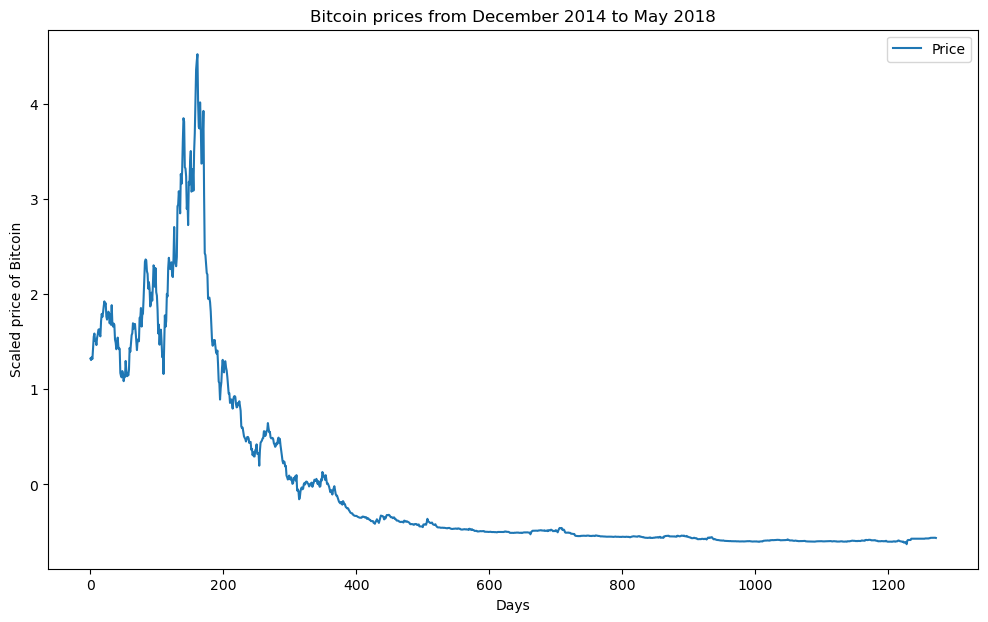

In [5]:
#data preprocessing(scaling)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_to_use.reshape(-1, 1))
#plotting the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Bitcoin prices from December 2014 to May 2018')
plt.xlabel('Days')
plt.ylabel('Scaled price of Bitcoin')
plt.plot(scaled_data, label='Price')
plt.legend()
plt.show()

In [7]:
# This function is used to create Features and Labels datasets. By windowing the data.
#Input: data - dataset used in the project
#window_size - how many data points we are going to use to predict the next datapoint in the sequence 
#[Example: if window_size = 1 we are going to use only the previous day to predict todays stock prices]
#Outputs: X - features splitted into windows of datapoints (if window_size = 1, X = [len(data)-1, 1])
#y - 'labels', actually this is the next number in the sequence, this number we are trying to predict

window_size = 7

def window_data(data):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y
#windowing the data with window_data function
X, y = window_data(scaled_data)


#we now split the data into training and test set
import numpy as np
X_train  = np.array(X[:1018])
y_train = np.array(y[:1018])

X_test = np.array(X[1018:])
y_test = np.array(y[1018:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1018, 7, 1)
y_train size: (1018, 1)
X_test size: (248, 7, 1)
y_test size: (248, 1)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

def build_model(batch_size, hidden_layer, learning_rate):
    model = Sequential()
    model.add(LSTM(hidden_layer, batch_input_shape=(batch_size, window_size, 1)))
    model.add(Dense(1))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss=MeanSquaredError(), optimizer=optimizer)
    
    return model

from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Parâmetros para o grid search
param_grid = {
    'batch_size': [5],
    'hidden_layer': [128],
    'learning_rate': [0.01, 0.1],
    'epochs': [10]
}

# Use o wrapper do keras para o sklearn
model = KerasRegressor(build_fn=build_model, verbose=1)

# Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, y_train)

# Mostra os resultados
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")


C:\Users\juliana_oikawa\AppData\Local\Temp\2\ipykernel_3556\2410876858.py:37: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, verbose=1)


Epoch 1/10
136/136 [==============================] - 5s 12ms/step - loss: 0.0055
Epoch 2/10
136/136 [==============================] - 2s 11ms/step - loss: 2.8190e-04
Epoch 3/10
136/136 [==============================] - 2s 12ms/step - loss: 2.5593e-04
Epoch 4/10
136/136 [==============================] - 2s 11ms/step - loss: 3.5676e-04
Epoch 5/10
 51/136 [==========>...................] - ETA: 1s - loss: 1.5036e-04

KeyboardInterrupt: 

In [21]:
grid_result.best_params_

{'batch_size': 5,
 'epochs': 10,
 'hidden_layer': 128,
 'learning_rate': 0.01,
 'window_size': 7}

In [ ]:
#IMPRIMIR METRICAS

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.spatial.distance import cosine
import numpy as np

# Preveja os valores com o modelo treinado
y_pred = grid_result.predict(X_test).flatten()

# Certifique-se de que y_test é 1-D
y_test_1d = y_test.flatten()

# Calcule e imprima MSE
mse = mean_squared_error(y_test_1d, y_pred)
print(f"MSE: {mse}")

# Calcule e imprima RMSE
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

# Calcule e imprima COSINE
cosine_similarity = 1 - cosine(y_test_1d, y_pred)
print(f"COSINE: {cosine_similarity}")



50/50 [==============================] - 0s 5ms/step
MSE: 0.0011639079166447033
RMSE: 0.0341160946863017
COSINE: 0.999980382398324


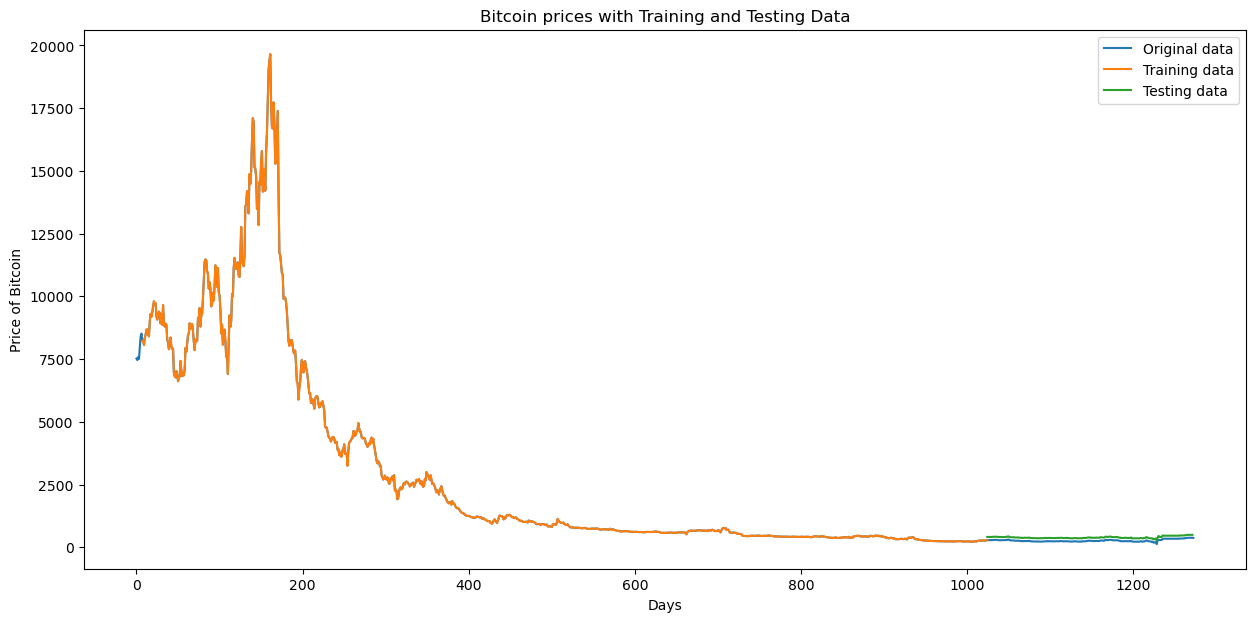

In [27]:
# Preparar os dados para plotar
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[7:len(y_train)+7, :] = scaler.inverse_transform(y_train.reshape(-1, 1))

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
test_plot[len(y_train)+7-1:len(scaled_data)-1, :] = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Plotar dados originais, de treinamento e de teste
plt.figure(figsize=(15,7))
plt.plot(scaler.inverse_transform(scaled_data), label='Original data')
plt.plot(train_plot, label='Training data')
plt.plot(test_plot, label='Testing data')
plt.title('Bitcoin prices with Training and Testing Data')
plt.xlabel('Days')
plt.ylabel('Price of Bitcoin')
plt.legend()
plt.show()
